In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import check_util.checker as checker
from IPython.display import clear_output
from PIL import Image

import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



#TENSER FLOW
import tensorflow as tf
from tensorflow.keras import layers
#GPU
print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

if (tf.test.is_gpu_available()):
    with tf.device('/device:GPU:0'):
        #your code here
        print("code here")


# Check the devices being used by TensorFlow
devices = tf.config.list_logical_devices()
for device in devices:
    print("Device:", device.name, "Type:", device.device_type)



tensorflow version: 2.9.0
GPU 사용 가능 여부: True
code here
Device: /device:CPU:0 Type: CPU
Device: /device:GPU:0 Type: GPU


2023-03-30 12:35:41.656364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 12:35:41.657762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-30 12:35:41.660137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 12:35:41.660145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
data_dir = './data/my_cat_dog'  # 압축 해제된 데이터셋의 디렉토리 경로
checker.dataset_check(data_dir)

훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 고양이 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 고양이 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000
dataset이 제대로 구성되어 있습니다! 이어서 진행하셔도 좋습니다.


### Parameters

In [27]:
print_steps = 1
val_epoch = 1

batch_size = 20
max_epochs = 20
learning_rate = 1e-4
IMG_SIZE = 150

PATH = data_dir

### LOAD test

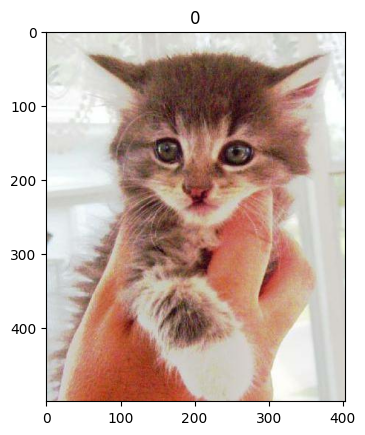

In [28]:
def load(image_file, label):
    # 해당경로의 파일을 읽어서 float 타입으로 변환합니다.
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.cast(image, tf.float32)

    return image, label

image, label = load(os.path.join(PATH, 'train/cat/cat.100.jpg'), 0)
# casting to int for matplotlib to show the image
plt.figure()
plt.title(label)
plt.imshow(image/255.0)
plt.show()

### Resize (255x225)

resize 함수를 잘 구현 하셨습니다! 이어서 진행하셔도 좋습니다.


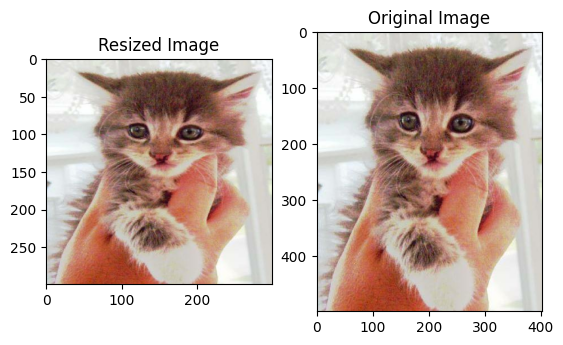

In [29]:
def resize(input_image, height, width):
    # 원하는 height와 width로 이미지를 resize 합니다.
    
    ## 코드 시작 ##
    input_image = tf.image.resize(input_image,size=(height,width))
    ## 코드 종료 ##
    
    return input_image

checker.resize_fn_check(resize)

plt.figure()
plt.subplot(121)
plt.title("Resized Image")
plt.imshow(resize(image, 300, 300)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()


### Rotation

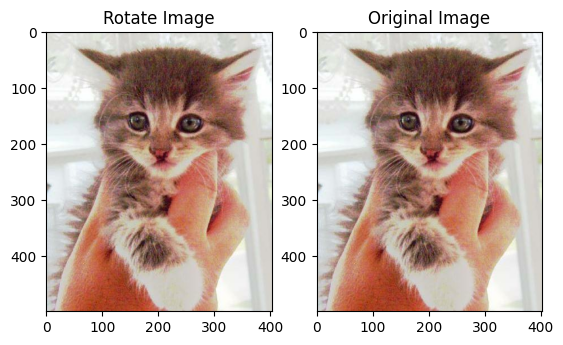

In [30]:
def random_rotation(input_image):
    # 이미지를 원하는 각도(radian)로 회전 시킵니다.
    
    ## 코드 시작 ##
    angles = np.random.randint(0,3)
    rotated_image = tf.image.rot90(input_image,k=angles)
    ## 코드 종료 ##  

    return rotated_image

plt.figure()
plt.subplot(121)
plt.title("Rotate Image")
plt.imshow(random_rotation(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

### Crop


random_crop 함수를 잘 구현 하셨습니다! 이어서 진행하셔도 좋습니다.


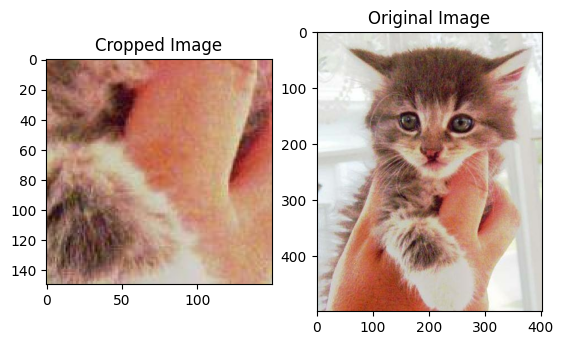

In [31]:
def random_crop(input_image):
    
    ## 코드 시작 ##
    #import random
    cropped_image = tf.image.random_crop(value=input_image, size=[IMG_SIZE, IMG_SIZE, 3])
    ## 코드 종료 ##

    return cropped_image
checker.random_crop_fn_check(random_crop)
plt.figure()
plt.subplot(121)
plt.title("Cropped Image")
plt.imshow(random_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

### Normalize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalize 함수를 잘 구현 하셨습니다! 이어서 진행하셔도 좋습니다.


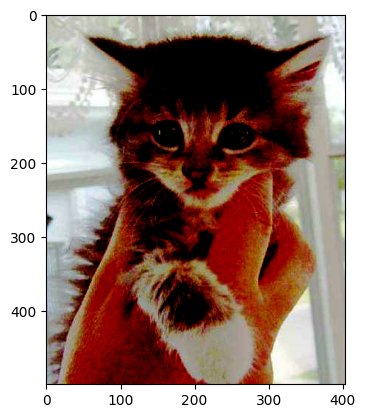

In [32]:
# normalizing the images to [-1, 1]
def normalize(input_image):
    # 이미지 픽셀값의 범위를 normalize 합니다. [0, 255] -> [-1, 1]
    
    # 코드 시작
    input_image = (input_image / (255/2))-1
    # 코드 종료
    
    return input_image


# def normalize(image):
#     #Normalizes an image by subtracting the mean and dividing by the standard deviation.
#     image = tf.cast(image, tf.float32)
#     mean = tf.math.reduce_mean(image)
#     std = tf.math.reduce_std(image)
#     return (image - mean) / std

checker.normalize_fn_check(normalize)

img = normalize(image)
plt.imshow(img)
plt.show()

### random mirror

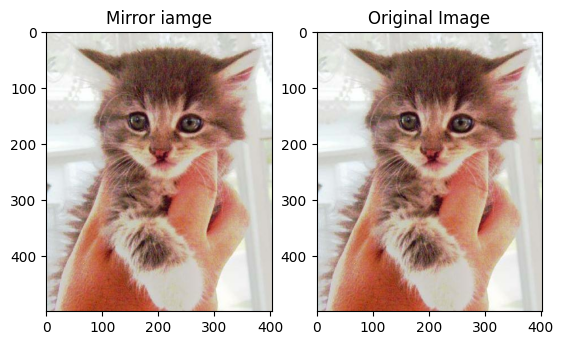

In [33]:


def rand_mirror(input_image):
    
    # Generate a random number to decide whether or not to mirror the image
    flip = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float32)
    #flip is between 1 and 0
    # Mirror the image horizontally if flip is greater than 0.5
    if flip > 0.5:
        input_image = tf.image.flip_left_right(input_image)
    
    return input_image

plt.figure()
plt.subplot(121)
plt.title("Mirror iamge")
plt.imshow(rand_mirror(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

### Sumup funk

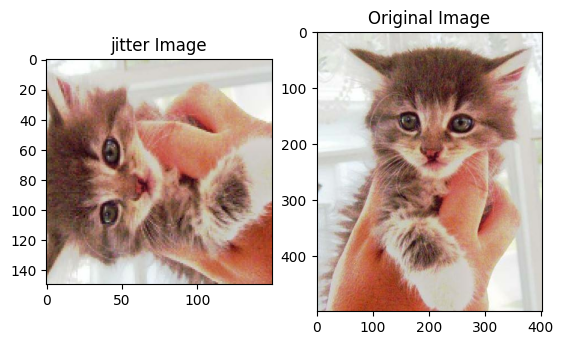

499

In [34]:
def random_jitter(input_image):
    # resize, random_crop, random_rotation, random_flip 함수들을 이용하여 augmentation을 합니다.

    ## 코드 시작 ##
    # resizing to 176 x 176 x 3
    input_image = resize(input_image,176,176)
    # randomly cropping to 150 x 150 x 3
    input_image = random_crop(input_image)
    # randomly rotation
    input_image = random_rotation(input_image)    
    # randomly mirroring
    input_image = rand_mirror(input_image)
    ## 코드 종료 ##

    return input_image

plt.figure()
plt.subplot(121)
plt.title("jitter Image")
plt.imshow(random_jitter(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()
image.shape[0]

### Central crop

검증(validation) 데이터나 테스트 데이터는 모델이 얼마나 잘 동작하는지를 평가하기 위한 데이터이기 때문에 이미지 증식을 적용하지 않고 원본 이미지를 사용해야 합니다. 이 때, 학습에 사용된 이미지 크기만큼 가운데를 잘라서 사용합니다. 이를 통해 학습과 평가에 일관성을 유지하고 모델을 공정하게 평가할 수 있습니다.


In image classification tasks, it is common practice to augment the training data with various transformations (such as random cropping, flipping, and rotation) to increase the amount and diversity of training examples. This can improve the generalization performance of the model. However, when evaluating the model on test or validation data, it is important to use the original, unaltered images to obtain an accurate assessment of the model's performance. Therefore, when testing or validating, we use the central crop of the original image (with the same size as the training images) instead of applying random transformations.

central_crop 함수를 잘 구현 하셨습니다! 이어서 진행하셔도 좋습니다.


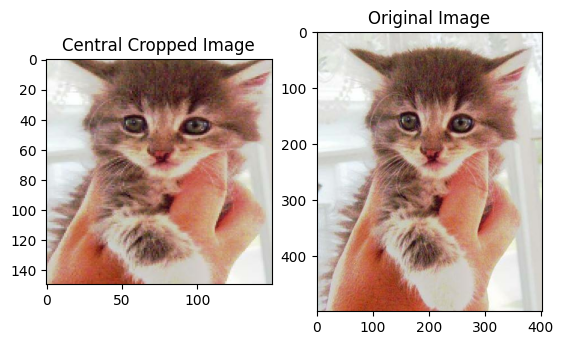

In [35]:
def central_crop(input_image):
    # 176 x 176 으로 resize후 150 x 150 중앙 crop 합니다.

    ## 코드 시작 ##
    # resizing to 176 x 176 x 3
    input_image = tf.image.resize(input_image,(176,176))
    # central cropping to 150 x 150 x 3
    input_image = tf.image.central_crop(input_image, central_fraction=IMG_SIZE/176)

    ## 코드 종료 ##

    return input_image
checker.central_crop_fn_check(central_crop)
plt.figure()
plt.subplot(121)
plt.title("Central Cropped Image")
plt.imshow(central_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

## Load image

In [36]:
def load_image_train(image_file, label):
    
    ## 코드 시작 ##
    print(image_file)
    print(label)
    input_image, label = load(image_file,label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)
    ## 코드 종료 ##

    return input_image, label

In [37]:
def load_image_val_and_test(image_file, label):
    
    ## 코드 시작 ##
    print(image_file)
    print(label)
    input_image, label = load(image_file,label)
    input_image = central_crop(input_image)
    input_image = normalize(input_image)
    ## 코드 종료 ##

    return input_image, label

### Make class list

### 

In [38]:
import os

# Define the root path for the 'train' folder
train_folder = os.path.join(PATH, 'train')

# Get a list of all items in the 'train' folder
all_items = os.listdir(train_folder)

# Initialize an empty list to store the folder names
folder_list = []

# Loop through all items in the 'train' folder
for f in all_items:
    # Check if the item does not start with a '.'
    if not f.startswith('.'):
        # Add the item to the folder_list
        folder_list.append(f)

# Now, folder_list contains all the folders in the 'train' directory, excluding hidden files/folders
print(folder_list)

['cat', 'dog']


## Train Dataset

In [39]:
#empt 
train_dataset = []
print(len(train_dataset))

0


In [40]:
def add_label(image_file, label):
    return image_file, label

In [41]:
#This is for Bin class


#bring the file names(folder_list[0] = cat)
train_dataset_cat = tf.data.Dataset.list_files(                            # 1번
    os.path.join(PATH, 'train', folder_list[0], '*.jpg'))

#make the cat file name list and add a '0' on that
train_dataset_cat = train_dataset_cat.map(lambda x: add_label(x, 0))


#bring the file names(folder_list[0] = cat)
train_dataset_dog = tf.data.Dataset.list_files(                            # 1번
    os.path.join(PATH, 'train', folder_list[1], '*.jpg'))

#make the cat file name list and add a '0' on that
train_dataset_dog = train_dataset_dog.map(lambda x: add_label(x, 1)) 

train_dataset = train_dataset_cat.concatenate(train_dataset_dog)


# train_dataset = tf.data.Dataset.list_files(                            # 1번
#     os.path.join(PATH, 'train', folder_list[0], '*.jpg'))
# train_dataset = train_dataset.map(lambda x: add_label(x, 0))          # 2번
# for label, category_name in enumerate(folder_list[1:], 1):            # 3번
#     temp_dataset = tf.data.Dataset.list_files(                         # 4번
#         os.path.join(PATH, 'train', category_name, '*.jpg'))
#     temp_dataset = temp_dataset.map(lambda x: add_label(x, label))    # 5번
#     train_dataset = train_dataset.concatenate(temp_dataset)            # 6번

train_iterator = train_dataset.as_numpy_iterator()
first_batch = next(train_iterator)
print(first_batch)


(b'./data/my_cat_dog/train/cat/cat.638.jpg', 0)


### Buffer size

In [42]:
N = BUFFER_SIZE = len(list(train_dataset)) # number of samples in train_dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                    num_parallel_calls=16)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=int32)


## Test Dataset

In [43]:

#These are for Bin class
# bring the file names of the test images

test_dataset_1 = tf.data.Dataset.list_files(os.path.join(PATH,'test',folder_list[0], '*.jpg'))


# add labels to the test dataset
test_dataset_1 = test_dataset_1.map(lambda x: add_label(x, 0)) 



# bring the file names of the test images
test_dataset_2 = tf.data.Dataset.list_files(os.path.join(PATH,'test',folder_list[1], '*.jpg'))

# add labels to the test dataset
test_dataset_2 = test_dataset_2.map(lambda x: add_label(x, 1)) 

test_dataset = test_dataset_1.concatenate(test_dataset_2)


test_dataset = test_dataset.map(load_image_val_and_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()


# folder_list = [f for f in os.listdir(os.path.join(PATH, 'val')) if not f.startswith('.')]
# val_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))
# val_dataset = val_dataset.map(lambda x: add_label(x, 0))
# for label, category_name in enumerate(folder_list[1:], 1):
#     temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', category_name, '*.jpg'))
#     temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
#     val_dataset = val_dataset.concatenate(temp_dataset)

# val_dataset = val_dataset.map(load_image_val_and_test)
# val_dataset = val_dataset.batch(batch_size)
# val_dataset = val_dataset.repeat()

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=int32)


### Validation dataset

In [44]:
#2 dim class
# folder_list = [f for f in os.listdir(os.path.join(PATH, 'val')) if not f.startswith('.')]
# val_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))
# val_dataset = val_dataset.map(lambda x: add_label(x, 0))
# for label, category_name in enumerate(folder_list[1:], 1):
#     temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', category_name, '*.jpg'))
#     temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
#     val_dataset = val_dataset.concatenate(temp_dataset)

# val_dataset = val_dataset.map(load_image_val_and_test)
# val_dataset = val_dataset.batch(batch_size)
# val_dataset = val_dataset.repeat()


#Bin class
val_dataset_1 = tf.data.Dataset.list_files(os.path.join(PATH,'val',folder_list[0], '*.jpg'))


# add labels to the test dataset
val_dataset_1 = val_dataset_1.map(lambda x: add_label(x, 0)) 



# bring the file names of the test images
val_dataset_2 = tf.data.Dataset.list_files(os.path.join(PATH,'val',folder_list[1], '*.jpg'))

# add labels to the test dataset
val_dataset_2 = val_dataset_2.map(lambda x: add_label(x, 1)) 

val_dataset = val_dataset_1.concatenate(val_dataset_2)

val_dataset = val_dataset.map(load_image_val_and_test)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=int32)


### Test-Adata augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


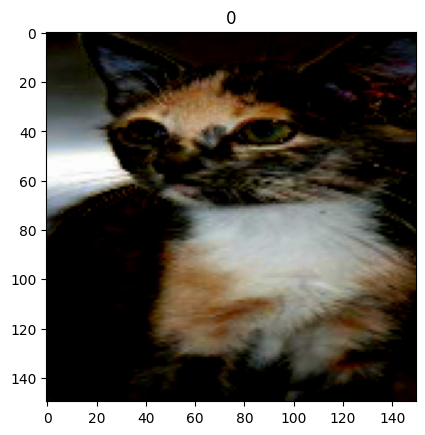

In [45]:
for images, labels in train_dataset.take(1):
    for j in range(1):
        plt.figure()
        plt.imshow(images[j])
        plt.title(labels[j].numpy())
        plt.show()

## Network!


Conv2D: A 2D convolution layer with 32 filters, a kernel size of 3x3, and a ReLU activation function.  

BatchNormalization: A layer that normalizes the input by adjusting and scaling the activations.  

MaxPooling2D: A 2D max pooling layer that reduces the size of the input by taking the maximum value within a window.  

Flatten: A layer that flattens the input into a 1D array.  

Dropout: A regularization technique that randomly drops out some units during training to prevent overfitting.  

Dense: A fully connected layer with a single output unit and a sigmoid activation function for binary classification.   

In [46]:
import tensorflow as tf

class BinaryClassificationModel(tf.keras.Model):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3))
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')
        self.pool3 = tf.keras.layers.MaxPooling2D((2, 2))
        self.flatten = tf.keras.layers.Flatten()
        #self.dense = tf.keras.layers.Dense(, activation='softmax')
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        output = self.dense(x)
        return output

    
model = BinaryClassificationModel()






In [47]:
#model(images[:1])

In [48]:
#model.summary()

### Before running the code

In [49]:
import tensorflow as tf

if tf.test.is_gpu_available():
    print('GPU is available')
else:
    print('GPU is NOT available')


GPU is available


2023-03-30 12:35:44.469513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 12:35:44.469552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Making a checkpoint to save the best model

In [50]:
checkpoint_path = "./train/exp_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

### Early stopping

you learned enogh

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)


In [52]:
#since I did repeat() ,  I need this to know the len 
# *2 is there because there are as much as folder0 in and folder1
train_len = len(glob(os.path.join(PATH, 'train', folder_list[0], '*.jpg'))) * 2
val_len = len(glob(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))) * 2
test_len = len(glob(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))) * 2

In [53]:
model.compile()

## LEARN!

In [54]:
NB_EPOCH = 5
BATCH_SIZE = 16


#model = BinaryClassificationModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.fit(train_dataset, steps_per_epoch=train_len//BATCH_SIZE,
#         validation_data=val_dataset,
#         validation_steps=val_len//BATCH_SIZE,
#         epochs=NB_EPOCH,
#         callbacks=cp_callback)

try:
        with tf.device('/device:GPU:0'):
                print("GPU activated")
                model.fit(train_dataset, steps_per_epoch=train_len//BATCH_SIZE,
                        validation_data=val_dataset,
                        validation_steps=val_len//BATCH_SIZE,
                        epochs=NB_EPOCH,
                        callbacks=cp_callback)
except:
        print("GPU error, switching to CPU...")
        with tf.device('/device:CPU:0'):
                model.fit(train_dataset, steps_per_epoch=train_len//BATCH_SIZE,
                        validation_data=val_dataset,
                        validation_steps=val_len//BATCH_SIZE,
                        epochs=NB_EPOCH,
                        callbacks=cp_callback)



GPU activated
Epoch 1/5


2023-03-30 12:35:44.949306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.5520

2023-03-30 12:35:52.525926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to ./train/exp_cnn/cp-0001.ckpt
125/125 [==============================] - 10s 71ms/step - loss: 0.6765 - accuracy: 0.5520 - val_loss: 0.6335 - val_accuracy: 0.6403
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.6492
Epoch 2: saving model to ./train/exp_cnn/cp-0002.ckpt
125/125 [==============================] - 8s 66ms/step - loss: 0.6278 - accuracy: 0.6492 - val_loss: 0.5975 - val_accuracy: 0.6815
Epoch 3/5
125/125 [==============================] - ETA: 0s - loss: 0.5798 - accuracy: 0.6844
Epoch 3: saving model to ./train/exp_cnn/cp-0003.ckpt
125/125 [==============================] - 8s 68ms/step - loss: 0.5798 - accuracy: 0.6844 - val_loss: 0.6270 - val_accuracy: 0.6798
Epoch 4/5
125/125 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7100
Epoch 4: saving model to ./train/exp_cnn/cp-0004.ckpt
125/125 [==============================] - 8s 67ms/step - loss: 0.5646 - accuracy: 0.7100 - val_loss:

#### Load last model

In [55]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint is not None:
    print(f"Loading checkpoint {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
else:
    print("No checkpoints found")

Loading checkpoint ./train/exp_cnn/cp-0005.ckpt


#### Check test dataset

In [56]:
for images, labels in test_dataset.take(5):
    print(images.shape, labels.shape)

(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)


## Evaluate

In [57]:

model.evaluate(test_dataset,steps = test_len/batch_size)

100/100 [==============================] - 3s 19ms/step - loss: 0.5565 - accuracy: 0.7090


[0.5564978122711182, 0.7090000510215759]

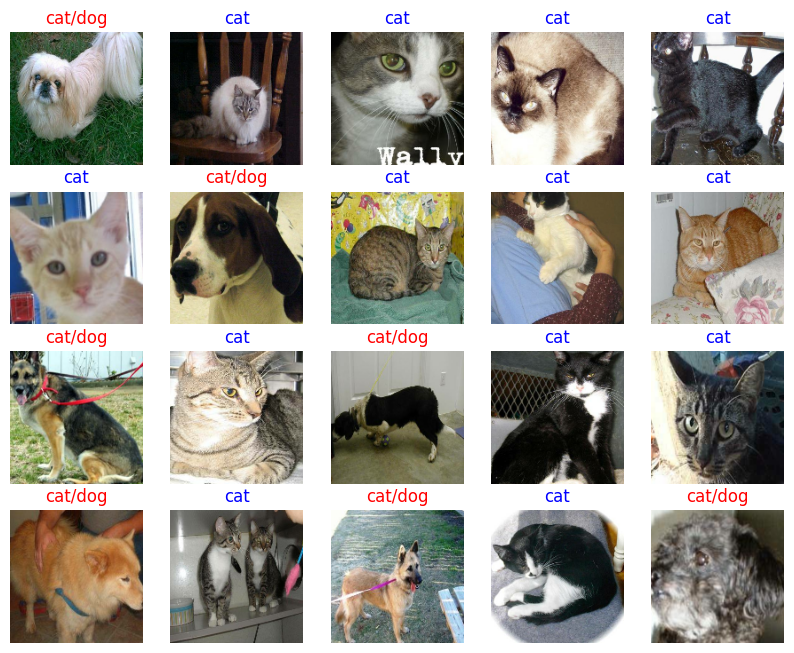

In [58]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():#correct
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:#wrong
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())]
                                ,labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

# 2 Class 

In [59]:
def load_image_train(image_file, label):
    
    ## 코드 시작 ##
    print(image_file)
    print(label)
    input_image, label = load(image_file,label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)
    ## 코드 종료 ##

    return input_image, label

In [60]:
def load_image_val_and_test(image_file, label):
    
    ## 코드 시작 ##
    print(image_file)
    print(label)
    input_image, label = load(image_file,label)
    input_image = central_crop(input_image)
    input_image = normalize(input_image)
    ## 코드 종료 ##

    return input_image, label

In [61]:
import os

# Define the root path for the 'train' folder
train_folder = os.path.join(PATH, 'train')

# Get a list of all items in the 'train' folder
all_items = os.listdir(train_folder)

# Initialize an empty list to store the folder names
folder_list = []

# Loop through all items in the 'train' folder
for f in all_items:
    # Check if the item does not start with a '.'
    if not f.startswith('.'):
        # Add the item to the folder_list
        folder_list.append(f)

# Now, folder_list contains all the folders in the 'train' directory, excluding hidden files/folders
print(folder_list)

['cat', 'dog']


In [62]:
#empt 
train_dataset = []
print(len(train_dataset))

0


In [63]:
def add_label(image_file, label):
    return image_file, label

In [64]:
train_dataset = tf.data.Dataset.list_files(                            # 1번
    os.path.join(PATH, 'train', folder_list[0], '*.jpg'))
train_dataset = train_dataset.map(lambda x: add_label(x, 0))          # 2번
for label, category_name in enumerate(folder_list[1:], 1):            # 3번
    temp_dataset = tf.data.Dataset.list_files(                         # 4번
        os.path.join(PATH, 'train', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))    # 5번
    train_dataset = train_dataset.concatenate(temp_dataset)            # 6번

In [65]:
N = BUFFER_SIZE = len(list(train_dataset)) # number of samples in train_dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=16)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=int32)


In [66]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'val')) if not f.startswith('.')]
val_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))
val_dataset = val_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    val_dataset = val_dataset.concatenate(temp_dataset)

val_dataset = val_dataset.map(load_image_val_and_test)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=int32)


In [67]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'test')) if not f.startswith('.')]
test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))
test_dataset = test_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    test_dataset = test_dataset.concatenate(temp_dataset)

test_dataset = test_dataset.map(load_image_val_and_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=int32)


In [68]:
checker.customized_dataset_check(train_dataset)

tf.data.Dataset을 이용하여 train_dataset을 잘 구현하셨습니다! 이어서 진행하셔도 좋습니다.


In [69]:
import tensorflow as tf

model2 = tf.keras.Sequential()

##코드 시작##
model2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150,150, 3), activation='relu'))
model2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model2.add(tf.keras.layers.Flatten())  # flatten
model2.add(tf.keras.layers.Dense(512, activation='relu'))  # relu
model2.add(tf.keras.layers.Dense(2, activation='softmax'))  # softmax
##코드 종료##


In [70]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 69, 69, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                    

In [71]:
checker.model_check(model2)

체크 함수를 실행하는 도중에 문제가 발생했습니다. 코드 구현을 완료했는지 다시 검토하시기 바랍니다.


In [72]:
import tensorflow as tf

if tf.test.is_gpu_available():
    print('GPU is available')
else:
    print('GPU is NOT available')


GPU is available


2023-03-30 12:36:34.324143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 12:36:34.324189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [73]:
checkpoint_path = "./train/exp_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

In [74]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [75]:
#since I did repeat() ,  I need this to know the len 
# *2 is there because there are as much as folder0 in and folder1
train_len = len(glob(os.path.join(PATH, 'train', folder_list[0], '*.jpg'))) * 2
val_len = len(glob(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))) * 2
test_len = len(glob(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))) * 2

In [76]:
model.compile()

In [77]:
NB_EPOCH = 3
BATCH_SIZE = 64



model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.fit(train_dataset, steps_per_epoch=train_len//BATCH_SIZE,
#         validation_data=val_dataset,
#         validation_steps=val_len//BATCH_SIZE,
#         epochs=NB_EPOCH,
#         callbacks=cp_callback)

try:
        with tf.device('/device:GPU:0'):
                print("GPU activated")
                model2.fit(train_dataset, steps_per_epoch=train_len//BATCH_SIZE,
                        validation_data=val_dataset,
                        validation_steps=val_len//BATCH_SIZE,
                        epochs=NB_EPOCH,
                        callbacks=cp_callback)
except:
        print("GPU error, switching to CPU...")
        with tf.device('/device:CPU:0'):
                model2.fit(train_dataset, steps_per_epoch=train_len//BATCH_SIZE,
                        validation_data=val_dataset,
                        validation_steps=val_len//BATCH_SIZE,
                        epochs=NB_EPOCH,
                        callbacks=cp_callback)



GPU activated
Epoch 1/3


2023-03-30 12:36:34.707040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 1.3492 - accuracy: 0.5065

2023-03-30 12:36:44.417348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to ./train/exp_cnn/cp-0001.ckpt
31/31 [==============================] - 14s 449ms/step - loss: 1.3492 - accuracy: 0.5065 - val_loss: 0.6946 - val_accuracy: 0.0000e+00
Epoch 2/3
31/31 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5177
Epoch 2: saving model to ./train/exp_cnn/cp-0002.ckpt
31/31 [==============================] - 13s 417ms/step - loss: 0.6930 - accuracy: 0.5177 - val_loss: 0.6840 - val_accuracy: 1.0000
Epoch 3/3
31/31 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5097
Epoch 3: saving model to ./train/exp_cnn/cp-0003.ckpt
31/31 [==============================] - 13s 415ms/step - loss: 0.6930 - accuracy: 0.5097 - val_loss: 0.6826 - val_accuracy: 1.0000


In [78]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint is not None:
    print(f"Loading checkpoint {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
else:
    print("No checkpoints found")

Loading checkpoint ./train/exp_cnn/cp-0003.ckpt


In [79]:
for images, labels in test_dataset.take(5):
    print(images.shape, labels.shape)

(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)


In [80]:

model.evaluate(test_dataset,steps = test_len/batch_size)

2023-03-30 12:37:15.366453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 2ms/step - loss: 0.0000e+00


0.0

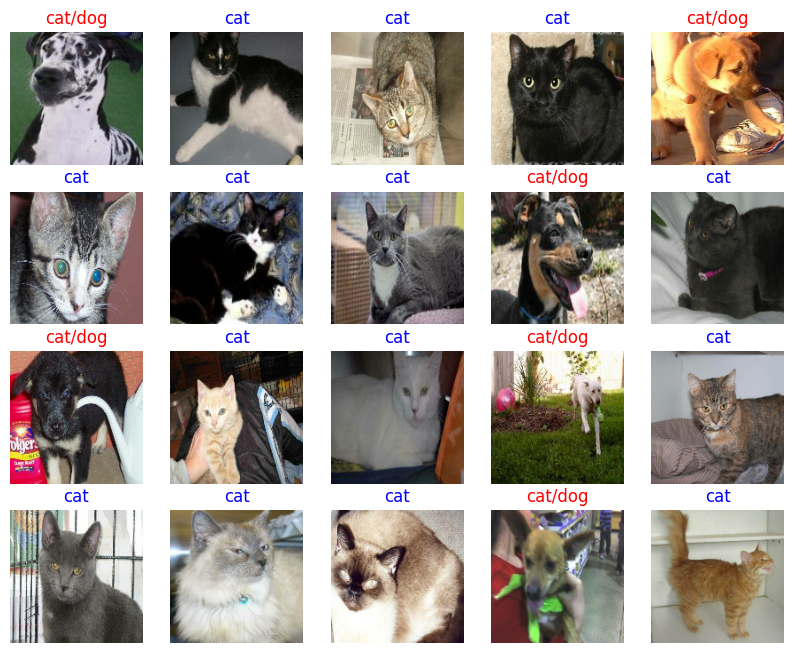

In [81]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():#correct
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:#wrong
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())]
                                ,labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

## Transfer Learning

Vgg16

In [82]:
#dont inlcude top since we need to fit out data input in to "input_shape"
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [83]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())

# 코드 시작
# model.add(layers.Dense(256 , activation = 'relu'))
# model.add(layers.Dense(256, activation = 'sigmoid'))
# 코드 종료

In [84]:
# training variable 확인
for var in model.trainable_variables:
    print(var.name)

block1_conv1/kernel:0
block1_conv1/bias:0
block1_conv2/kernel:0
block1_conv2/bias:0
block2_conv1/kernel:0
block2_conv1/bias:0
block2_conv2/kernel:0
block2_conv2/bias:0
block3_conv1/kernel:0
block3_conv1/bias:0
block3_conv2/kernel:0
block3_conv2/bias:0
block3_conv3/kernel:0
block3_conv3/bias:0
block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0


In [85]:
#learn in only conv_block5

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [86]:
# training variable 확인
for var in model.trainable_variables:
    print(var.name)

block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0


In [87]:
checker.final_dense_check(model)

체크 함수를 실행하는 도중에 문제가 발생했습니다. 코드 구현을 완료했는지 다시 검토하시기 바랍니다.


In [88]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [89]:
# checkpoint_path = "./train/exp_cnn/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq='epoch')

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)


In [91]:
NB_EPOCH = 5
BATCH_SIZE = 64

# model.fit(train_dataset, steps_per_epoch=train_len//BATCH_SIZE,
#         validation_data=val_dataset,
#         validation_steps=val_len//BATCH_SIZE,
#         epochs=NB_EPOCH,
#         callbacks=cp_callback)

model.fit(train_dataset, steps_per_epoch=train_len//BATCH_SIZE,
        validation_data=val_dataset,
        validation_steps=val_len//BATCH_SIZE,
        epochs=NB_EPOCH,
        )

Epoch 1/5


2023-03-30 12:37:18.839079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 11.2521 - accuracy: 0.1532

2023-03-30 12:37:25.891204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 10s 307ms/step - loss: 11.2521 - accuracy: 0.1532 - val_loss: 2.7724 - val_accuracy: 0.2533
Epoch 2/5
31/31 [==============================] - 10s 313ms/step - loss: 10.8835 - accuracy: 0.1129 - val_loss: 2.7724 - val_accuracy: 0.2233
Epoch 3/5
31/31 [==============================] - 9s 301ms/step - loss: 10.7276 - accuracy: 0.1194 - val_loss: 2.7726 - val_accuracy: 0.2067
Epoch 4/5
31/31 [==============================] - 10s 316ms/step - loss: 11.2469 - accuracy: 0.1226 - val_loss: 2.7726 - val_accuracy: 0.2367
Epoch 5/5
31/31 [==============================] - 10s 318ms/step - loss: 11.1693 - accuracy: 0.1097 - val_loss: 2.7726 - val_accuracy: 0.2067


In [92]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest_checkpoint)

In [93]:
for images, labels in test_dataset.take(5):
    print(images.shape, labels.shape)

(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)
(20, 150, 150, 3) (20,)


In [94]:
model.evaluate(test_dataset,steps = test_len/batch_size)

100/100 [==============================] - 19s 174ms/step - loss: 10.8316 - accuracy: 0.1350


[10.831624984741211, 0.13500000536441803]

KeyError: 512

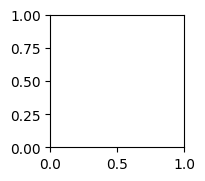

In [96]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():#correct
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:#wrong
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())]
                                ,labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

## Code Diary: A Summary of Progress

1. Created a new file to start from the beginning.  
2. Learned that for the train dataset, random jitter is used, while crop is used for test and validation datasets.  
3. Spent considerable time installing TensorFlow for M1 GPU to enable GPU usage.  
4. Simplified the train dataset.  
5. Encountered an error in model.fit due to the M1 chip; resolved by downgrading TensorFlow version.  
6. Discovered that repeat() means infinite; adjusted code to determine the length of train, validation, and test datasets.  
7. Learned about steps per epoch in model.fit due to the usage of repeat().  
8. Implemented callback to save the best model.  
9. Employed early stopping to save time and prevent overfitting.  
10. Identified a learning issue where the model only predicted 'cat'; found that the dog dataset was not included and fixed the problem. (I noticed by looking at the image file in the folder, the len(test_dataset) was 1000 and the total cat image was 1000, so that means the dog image was not included in the test dataset)  
11. I got a code from my co-worker, and I notice two things. One is that he was using class and model.add to make the model (I dont understand why he does it like that. I choose only one of those). And second is that he was using Dense 256 as a last dense. This is not what I expected since I did dense 1 (for bin class) or dense 2 (for 2 class). I asked him about it and he didnt even knew why. He just did it and worked.


## 코드 다이어리: 진행 상황 요약

1. 처음부터 시작할 수 있는 새 파일 생성.  
2. 훈련 데이터셋에는 랜덤 지터가 사용되며, 테스트 및 검증 데이터셋에는 크롭이 사용된다는 것을 배움.  
3. M1 GPU에서 텐서플로우를 사용할 수 있도록 설치하는 데 상당한 시간 소요.  
4. train_dataset, test_dataset 을 단순화.  
5. M1 chip 때문에 model.fit에서 오류 발생; 텐서플로우 버전을 다운그레이드하여 해결.  
6. repeat()가 무한을 의미한다는 것을 알게 되었고, 훈련, 검증, 테스트 데이터셋의 길이 (len(test_dataset))를 결정하기 위해 코드를 따로 작성.  
7. repeat() 사용으로 인한 model.fit의 steps_per_epoch 대해 배움.  
8. 최적의 모델을 저장하기 위해 callback 구현.  
9. 시간을 절약하고 과적합을 방지하기 위해 early stop 사용.  
10. 모델이 '고양이'만 예측하는 학습 문제 발견; 강아지 데이터셋이 포함되지 않았음을 발견하고 문제 수정. (폴더의 이미지 파일을 확인해보니 len(test_dataset)이 1000이고 총 고양이 이미지가 1000개였으므로, 강아지 이미지가 테스트 데이터셋에 포함되지 않았음을 알게 되었습니다.)
11. pretrained 모델을 학습할때, 출력함수 갯수를 안맞춰도 돌아가긴함. 아무것도 안마추고 돌아가면 정확도가 10%나옴. 뭔가 자체적으로 수정하는 자동기능이 있는듯, 더 깊이 파고 들어가면 너무 깊어질것 같아서, 여기까지만 하고 파이토치로 복귀
